In [13]:
import os
import torchvision
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import pandas as pd 
from datetime import datetime
from itertools import product

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import warnings
warnings.filterwarnings("ignore")

In [14]:
def show_slices(slices):
    #Function to display row of image slices
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

def print_img(img):
    slice_0 = img[img.shape[0]//2,:,:]
    slice_1 = img[:,img.shape[1]//2, :]
    slice_2 = img[:,:,img.shape[2]//2]
    show_slices([slice_0, slice_1, slice_2])

def print_coronal(img, title):
    slice_1 = img[:,img.shape[1]//2, :]
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(3,3))
    # Plot the image on the axes
    ax.imshow(slice_1.T, cmap="gray", origin="lower")
    # Show the plot
    plt.suptitle(title)
    plt.show()

# load data

In [23]:
df = pd.read_csv("patched_paired_input_CVAE.csv", index_col=0)
print(df['age1'].min(), df['age1'].max(), df['timeDiff'].min(), df['timeDiff'].max())
print(df['status'].value_counts())

## will do this later with the images
df['age1'] = (df['age1']-df['age1'].mean())/df['age1'].std()
print(df['age1'].mean(), df['age1'].std())

timeDiff_mean = df['timeDiff'].mean()
timeDiff_std = df['timeDiff'].std()

df['timeDiff'] = (df['timeDiff']-df['timeDiff'].mean())/df['timeDiff'].std() 
print(df['timeDiff'].mean(),df['timeDiff'].std())

# df

pair_imgs = df.values
pair_imgs.shape

55.1 95.8 -9.791221366057838 9.791221366057838
status
1    44280
0    32008
3    21760
2    12656
5    10544
4     3384
Name: count, dtype: int64


,img1,age1,img2,age2,status,timeDiff,patch_num
0,0-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0,0.000000,0
1,1-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,1-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0,0.000000,1
2,2-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,2-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0,0.000000,2
3,3-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,3-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0,0.000000,3
4,4-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,4-002_S_0295_MPRAGE_2011-06-02_07_58_50.0.npy,90.0,0,0.000000,4
...,...,...,...,...,...,...,...
124627,3-941_S_5193_MPRAGE_2015-04-02_11_01_34.0.npy,74.4,3-941_S_5193_MPRAGE_2013-08-19_12_15_23.0.npy,72.8,4,-1.619038,3
124628,4-941_S_5193_MPRAGE_2015-04-02_11_01_34.0.npy,74.4,4-941_S_5193_MPRAGE_2013-08-19_12_15_23.0.npy,72.8,4,-1.619038,4
124629,5-941_S_5193_MPRAGE_2015-04-02_11_01_34.0.npy,74.4,5-941_S_5193_MPRAGE_2013-08-19_12_15_23.0.npy,72.8,4,-1.619038,5
124630,6-941_S_5193_MPRAGE_2015-04-02_11_01_34.0.npy,74.4,6-941_S_5193_MPRAGE_2013-08-19_12_15_23.0.npy,72.8,4,-1.619038,6


# VAE model

### dataloader, each input is [img2, img1], and scalar input [age1, timediff, status, one hot encoding for patch]

In [33]:
from torch.utils.data import Dataset, DataLoader
import nibabel as nib

# build data loader
class BrainDataset(Dataset):
    
    '''Load a random 3D image'''
    def __init__(self, files):
        self.files = files
        self.n_files = len(self.files) 

    def __len__(self):
        return self.n_files
    
    def __getitem__(self,idx):
        fname = self.files[idx]
        
        path = ""
        image1 = torch.Tensor(np.load(path+fname[0])).unsqueeze(0)
        image2 = torch.Tensor(np.load(path+fname[2])).unsqueeze(0)
        
        age1 = fname[1]
        age2 = fname[-2]
        status = fname[4]
        patch_num = fname[-1]
        
        ## we want multi-channel images, so size stays the same
        ## input shape [batch_size, 2, 45,45,45]
        paired_inputs = torch.cat((image2, image1), 0)
        scalar_vars = [age1, age2, status, 0,0,0,0,0,0,0,0]
        scalar_vars[patch_num+3] = 1

        return paired_inputs.to(torch.float32), torch.Tensor(scalar_vars).to(torch.float32)
            
b_size = 32

dataset = BrainDataset(pair_imgs)
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=True, num_workers=8)

## basic blocks

In [35]:
# settings for reproducibility
# torch.manual_seed(1999)

# misc
def parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# helper block function
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, scalar_size=11):
        super(Conv, self).__init__()
        
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias=True)
        self.linear = nn.Linear(scalar_size, out_channels)
        self.norm = nn.GroupNorm(4, out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x, sca):
        x = self.conv(x)
        sca = self.linear(sca)
        
        x = x + sca.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        x = self.norm(x)
        return self.relu(x)
    
class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, pad, out_pad=[0,0,0]):
        super(ConvTranspose, self).__init__()
        
        self.convTran = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride, padding=pad,
                               output_padding=out_pad, bias=False),
            nn.GroupNorm(4, out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.convTran(x)

## model definition

In [36]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        base = 64
        kernel_size = [3,3,3]
        stride_size = [1,1,1]
        padding_size = [1,1,1]

        maxpool_kernel_size = [2,2,2]
        maxpool_stride_size = [2,2,2]
        
        convTrans_kernel = [2,2,2]
        convTrans_stride = [2,2,2]
        
        ### ENCODER: 4 layers of convolutions + 3 downsampling
        self.e1 = Conv(2, base, kernel_size, stride=stride_size, padding=padding_size)
        self.e2 = Conv(base, base, kernel_size, stride=stride_size, padding=padding_size)
        self.p1 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        self.e3 = Conv(base, 2*base, kernel_size, stride=stride_size, padding=padding_size)
        self.e4 = Conv(2*base, 2*base, kernel_size, stride=stride_size, padding=padding_size)
        self.p2 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        self.e5 = Conv(2*base, 4*base, kernel_size, stride=stride_size, padding=padding_size)
        self.e6 = Conv(4*base, 4*base, kernel_size, stride=stride_size, padding=padding_size)
        self.p3 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        self.e7 = Conv(4*base, 8*base, kernel_size, stride=stride_size, padding=padding_size)
        self.e8 = Conv(8*base, 8*base, kernel_size, stride=stride_size, padding=padding_size)
        self.last_linear = nn.Linear(5*5*5*8*base, 20) #4*4*4*8*base, 20)
        
        
        ## U-Net decoder, encoder part for only the image+conditionals
        self.u_down1 = Conv(1, base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_down2 = Conv(base, base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_pool1 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        self.u_down3 = Conv(base, 2*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_down4 = Conv(2*base, 2*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_pool2 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        self.u_down5 = Conv(2*base, 4*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_down6 = Conv(4*base, 4*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_pool3 = nn.MaxPool3d(kernel_size=maxpool_kernel_size, stride=maxpool_stride_size)

        ## decoder latent space add directly here at the bottleneck
        self.u_down7 = Conv(4*base, 8*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.u_down8 = Conv(8*base, 8*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        
        ## decoder up part
        self.t1 = ConvTranspose(8*base, 4*base, convTrans_kernel, stride=convTrans_stride, 
                                pad=[0,0,0], out_pad=[1,1,1])
        self.d1 = Conv(8*base, 4*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.d2 = Conv(4*base, 4*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)

        self.t2 = ConvTranspose(4*base, 2*base, convTrans_kernel, stride=convTrans_stride, 
                                pad=[0,0,0])
        self.d3 = Conv(4*base, 2*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.d4 = Conv(2*base, 2*base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)

        self.t3 = ConvTranspose(2*base, base, convTrans_kernel, stride=convTrans_stride, 
                                pad=[0,0,0], out_pad=[1,1,1])
        self.d5 = Conv(2*base, base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        self.d6 = Conv(base, base, kernel_size, stride=stride_size, padding=padding_size, scalar_size=21)
        
        self.last_conv = nn.Conv3d(base, 1, [1,1,1], [1,1,1], bias=True)

    def encode(self, x, scalar):
        x = self.e1(x, scalar)
        x = self.e2(x, scalar)
        x = self.p1(x)
        
        x = self.e3(x, scalar)
        x = self.e4(x, scalar)
        x = self.p2(x)
        
        x = self.e5(x, scalar)
        x = self.e6(x, scalar)
        x = self.p3(x)
        
        x = self.e7(x, scalar)
        x = self.e8(x, scalar)
        return self.last_linear(x.view(x.size(0), -1))
    
    
    def to_mu_sigma(self, out):
        mu = out[:,:10]
        logsigma2 = out[:,10:]  

        sigma = torch.exp(0.5*logsigma2)
        return mu, sigma
    
    def reparameterize(self, mu, sigma):
        tmp1 = torch.randn(mu.shape).to(device)
        return mu + tmp1*sigma
    
    def decode(self, z, scalar, img1):
        latent_scalar = torch.cat((z, scalar), dim=1)
        
        ## u-net strucutre, downsize part just img 1
        out = self.u_down1(img1, latent_scalar)
        skip1 = self.u_down2(out, latent_scalar)
        out = self.u_pool1(skip1)
        
        out = self.u_down3(out, latent_scalar)
        skip2 = self.u_down4(out, latent_scalar)
        out = self.u_pool2(skip2)
        
        out = self.u_down5(out, latent_scalar)
        skip3 = self.u_down6(out, latent_scalar)
        out = self.u_pool3(skip3)
        
        out = self.u_down7(out, latent_scalar)
        out = self.u_down8(out, latent_scalar)
        
        ## u-net strucutre, upsize part
        out = self.t1(out)
        out = self.d1(torch.cat([out, skip3], 1), latent_scalar)
        out = self.d2(out, latent_scalar)
        
        out = self.t2(out)
        out = self.d3(torch.cat([out, skip2], 1), latent_scalar)
        out = self.d4(out, latent_scalar)
        
        out = self.t3(out)
        out = self.d5(torch.cat([out, skip1], 1), latent_scalar)
        out = self.d6(out, latent_scalar)
                
        return self.last_conv(out)

    
    def forward(self, x, scalar, img1):
        ## out is size (batch, 20)
        out = self.encode(x, scalar)
                
        mu, sigma = self.to_mu_sigma(out)
        z = self.reparameterize(mu, sigma)
        latent_scalar = torch.cat((z, scalar), dim=1)
        
        ## u-net strucutre, downsize part just img 1
        out = self.u_down1(img1, latent_scalar)
        skip1 = self.u_down2(out, latent_scalar)
        out = self.u_pool1(skip1)
        
        out = self.u_down3(out, latent_scalar)
        skip2 = self.u_down4(out, latent_scalar)
        out = self.u_pool2(skip2)
        
        out = self.u_down5(out, latent_scalar)
        skip3 = self.u_down6(out, latent_scalar)
        out = self.u_pool3(skip3)
        
        out = self.u_down7(out, latent_scalar)
        out = self.u_down8(out, latent_scalar)
        
        ## u-net strucutre, upsize part
        out = self.t1(out)
        out = self.d1(torch.cat([out, skip3], 1), latent_scalar)
        out = self.d2(out, latent_scalar)
        
        out = self.t2(out)
        out = self.d3(torch.cat([out, skip2], 1), latent_scalar)
        out = self.d4(out, latent_scalar)
        
        out = self.t3(out)
        out = self.d5(torch.cat([out, skip1], 1), latent_scalar)
        out = self.d6(out, latent_scalar)
        
        out = self.last_conv(out)
        
        return out, mu, sigma

print('parameter count:', parameter_count(CVAE()))


parameter count: 37819285


### train

In [37]:
init_lr = 1e-5
num_epochs = 1000
# sigma = 0.1/Istd 

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# model
cvae = CVAE()
cvae.to(device)
cvae.cuda()

# optimizer
optimizer = optim.Adam(cvae.parameters(), lr=init_lr)

# criterion, might need to add term for how accurate/noisy the samples are, include the sigma
# since I standardized my data, my standard deviation is 0.1. Set it to be small so the KLD is
# negligible, we just have reconstruction
l2_loss = nn.MSELoss(reduction='sum')

def kld_loss(mu,sigma2):
    return 0.5*torch.sum(mu**2 + sigma2 - 1 - torch.log(sigma2))

## if image has lots of variance, the generator just outputs an average images
## if has small amount of variance, it seems to fit the samples well but difficult to interpolate
def criterion(img2_batch, recon, mu, sigma2):
    recon_loss = l2_loss(recon, img2_batch)/(2*0.1*0.1)
    kl_loss = kld_loss(mu,sigma2)
    return recon_loss+kl_loss, recon_loss.item(), kl_loss.item()

cuda:0


In [ ]:
# statistics
train_losses = []
test_losses = []

recon_loss_arr = []
kl_loss_arr = []

for epoch in range(num_epochs):
    cvae.train(True)
    running_loss = 0.0
    recon_loss_e = 0.0
    kl_loss_e = 0.0

    for img_batch, scalar_batch in dataloader:
        optimizer.zero_grad()
        
        img_batch = img_batch.cuda()
        scalar_batch = scalar_batch.cuda()
        
        # forward + backward + optimize
        recon, mu, sigma = cvae(img_batch, scalar_batch, img_batch[:,1:2,...])
        loss, recon_l, kl_l = criterion(img_batch[:,0:1,...], recon, mu, sigma**2)
       
        # statistics
        running_loss += loss.item()
        recon_loss_e += recon_l
        kl_loss_e += kl_l
        
        loss.backward()
        optimizer.step()
                
    running_loss /= (pair_imgs.shape[0] // b_size)
    recon_loss_e /= (pair_imgs.shape[0] // b_size)
    kl_loss_e /= (pair_imgs.shape[0] // b_size)
    
    train_losses.append(running_loss)
    recon_loss_arr.append(recon_loss_e)
    kl_loss_arr.append(kl_loss_e)
    
    # output
    print('Epoch {} -- loss: {:.4f}'.format(epoch + 1, running_loss))
    
    if epoch%100 == 99:
        torch.save(cvae, 'CVAE_'+str(epoch)+'.pt')
        np.savetxt("CVAE_recon", recon_loss_arr)
        np.savetxt("CVAE_kl", kl_loss_arr)

    # visualize reconstruction and synthesis
    if epoch==num_epochs-1:
        torch.save(cvae.state_dict(), 'CVAE.state_dict')

## Evaluation

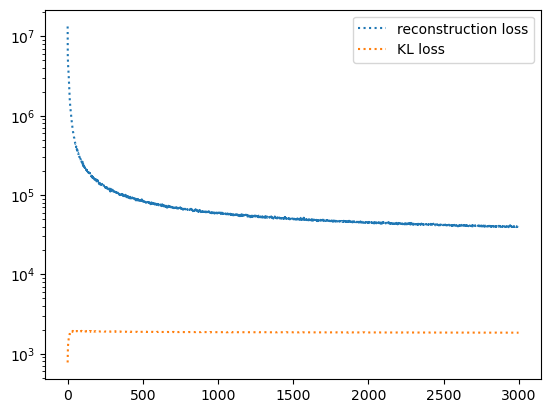

In [17]:
plt.plot(recon_loss, linestyle = 'dotted', label='reconstruction loss')
plt.plot(kl_loss, linestyle = 'dotted', label='KL loss')
# plt.ylim(0, 50)
plt.yscale('log')
plt.legend()
plt.show()